# <mark>PyTorch:</mark> VGG19 Implementation W/Imagewoof

In [1]:
# PyTorch Utils
import torch
from torch.utils.data import TensorDataset, DataLoader, Subset, random_split
from torchvision.transforms import v2 as T
from torchvision import datasets
import torchvision.models as models
import torch.nn as nn
import torchvision
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

# MatPlot
import matplotlib.pyplot as plt

# NumPy
import numpy as np

# Pandas
import pandas as pd

# Other Utils
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

In [2]:
# Debug CUDA information
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
 
# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device: {torch.cuda.current_device()}")
print(f"Name of current CUDA device: {torch.cuda.get_device_name(cuda_id)}")

Is CUDA supported by this system? True
CUDA version: 12.1
ID of current CUDA device: 0
Name of current CUDA device: NVIDIA GeForce GTX 1650


In [3]:
# Device usage definition
device = ("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

### Image Processing For Future Display

In [4]:
def process_image(img, transpose=False):
    """
    Preprocess the images to displays them in a plot.

    Parameters:
    - img: The image to preprocess.
    - transpose: Bool value if the img needs to be transposed.

    Returns:
    - img: The image preprocessed.       
    """
    if transpose:
        img = img.numpy().transpose((1, 2, 0)) # Transform (X, Y, Z) shape
    img = (img - img.min()) / (img.max() - img.min()) # Clip the image to [0, 255] values
    return img

### Load Imagewoof Dataset

The images are 320x320, with pixel values ranging from 0 to 255. The labels are an array of strings, ranging from 0 to 9. These correspond to the class of clothing the image represents:

| <div style="width:300px">**Label**</div> |  <div style="width:300px">**Class**</div>  |
|:---------------|:---------------|
| n02086240      | Shih-Tzu |
| n02087394      | Rhodesian ridgeback |
| n02088364      | Beagle |
| n02089973      | English foxhound |
| n02093754      | Border terrier |
| n02096294      | Australian terrier |
| n02099601      | Golden retriever |
| n02105641      | Old English sheepdog |
| n02111889      | Samoyed |
| n02115641      | Dingo |

<br>

In [5]:
# Define the directory where your dataset is located
data_dir = 'Datasets/Imagewoof'

In [6]:
# Define the transformations you want to apply to the images
data_transforms = {
    'train': T.Compose([
        T.ToImage(), # Convert to tensor, because the image comes has PIL
        T.Resize(size=(224, 224)),
        T.RandomResizedCrop(size=(200, 200), antialias=True),
        T.RandomHorizontalFlip(),
        T.RandomGrayscale(p=0.1),
        T.ToDtype(torch.float32, scale=True),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': T.Compose([
        T.ToImage(), # Convert to tensor, because the image comes has PIL
        T.Resize(size=(224, 224)),
        T.CenterCrop(224),
        T.ToDtype(torch.float32, scale=True),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [7]:
# Create datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

In [8]:
# Create dataloaders
dataloaders = {x: DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=4) for x in ['train', 'val']}

### Define New Classes With the Correct Dog Breeds

In [9]:
# Correct dog breeds
dog_breeds = [
    'Shih-Tzu', 'Rhodesian Ridgeback', 'Beagle', 'English Foxhound', 'Border Terrier',
    'Australian Terrier', 'Golden Retriever', 'Old English Sheepdog', 'Samoyed', 'Dingo'
]

# Assing the dog breeds to the class names
class_names = dog_breeds

### Iterating and Visualising the Dataset

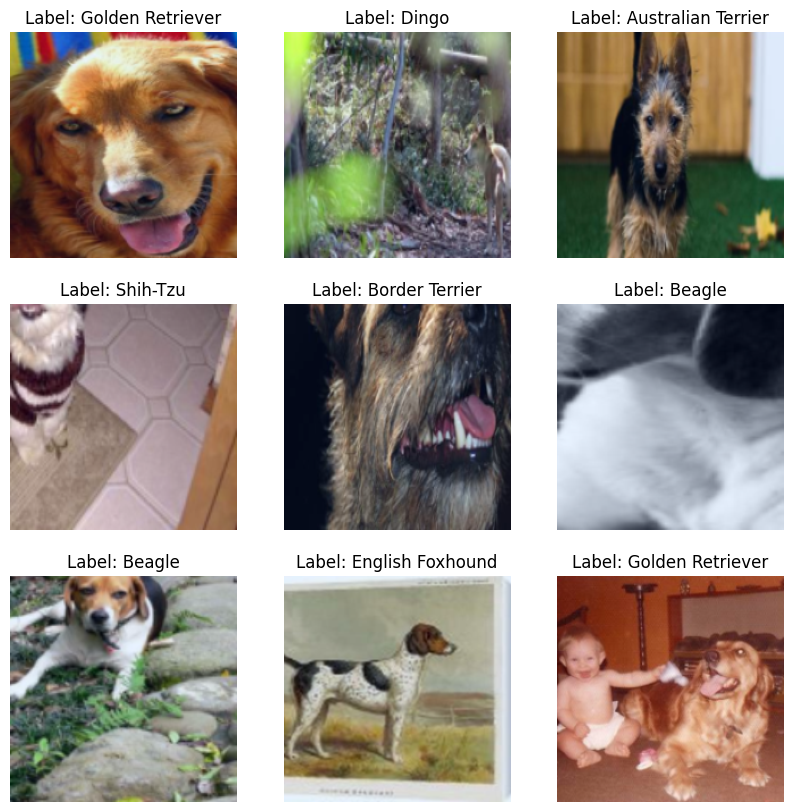

In [10]:
# Get a batch of images and labels
imgs, labels = next(iter(dataloaders['train']))

# Plot the images
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    # Convert the tensor to numpy array and transpose the dimensions if necessary
    img_np = imgs[i].numpy().transpose((1, 2, 0)) if isinstance(imgs, torch.Tensor) else imgs[i]
    img_np = process_image(img_np)
    
    ax.imshow(img_np)
    ax.set_title(f'Label: {class_names[labels[i]]}')
    ax.axis('off')

plt.show()

### Create Test Set (Subset of 20% of the Validation Set)

In [ ]:
# Define the size of the test dataset (e.g., 20% of the validation set)
test_size = int(0.2 * len(val_data))
val_size = len(val_data) - test_size

In [ ]:
# Use random_split to split the validation dataset into validation and test datasets
val_data, test_data = random_split(val_data, [val_size, test_size])

In [ ]:
# Create DataLoader objects for validation and test subsets
val_dataloader = DataLoader(val_data, batch_size=4, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_data, batch_size=4, shuffle=False, num_workers=4)

In [ ]:
# Length of the training set
train_set_length = len(training_data)
print("Length of the train set:", train_set_length)

# Length of the validation set
validation_set_length = len(val_data)
print("Length of the validation set:", validation_set_length)

# Length of the test set
test_set_length = len(test_data)
print("Length of the test set:", test_set_length)

### Model Creation + Training

In [11]:
# Load pre-trained VGG19 model
model = models.vgg19(weights='DEFAULT')

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /home/joseareia/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 548M/548M [04:46<00:00, 2.00MB/s]


In [12]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

In [13]:
# Modify the last fully connected layer for the number of classes in Imagewoof (10 classes)
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 10)

In [14]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [15]:
# Switch the model to CUDA device
model = model.to(device)

In [16]:
# Train the model
num_epochs = 10

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward
            # Track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(image_datasets[phase])
        epoch_acc = running_corrects.double() / len(image_datasets[phase])

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

Epoch 1/10
----------
train Loss: 0.5145 Acc: 0.8287
val Loss: 0.1880 Acc: 0.9392
Epoch 2/10
----------
train Loss: 0.4324 Acc: 0.8545
val Loss: 0.1689 Acc: 0.9450
Epoch 3/10
----------
train Loss: 0.4091 Acc: 0.8636
val Loss: 0.1701 Acc: 0.9425
Epoch 4/10
----------
train Loss: 0.4251 Acc: 0.8535
val Loss: 0.2080 Acc: 0.9382
Epoch 5/10
----------
train Loss: 0.4173 Acc: 0.8649
val Loss: 0.1731 Acc: 0.9435
Epoch 6/10
----------
train Loss: 0.4012 Acc: 0.8683
val Loss: 0.1626 Acc: 0.9458
Epoch 7/10
----------
train Loss: 0.4349 Acc: 0.8534
val Loss: 0.1726 Acc: 0.9455
Epoch 8/10
----------
train Loss: 0.4216 Acc: 0.8572
val Loss: 0.1733 Acc: 0.9430
Epoch 9/10
----------
train Loss: 0.4029 Acc: 0.8663
val Loss: 0.1711 Acc: 0.9460
Epoch 10/10
----------
train Loss: 0.4099 Acc: 0.8628
val Loss: 0.1750 Acc: 0.9440


### Save Model

In [17]:
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('./Models/ModelVGG19.pt') # Save

### <mark>Load Model!</mark>

In [18]:
model = torch.jit.load('./Models/ModelVGG19.pt') # Load
model.eval()

RecursiveScriptModule(
  original_name=VGG
  (features): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Conv2d)
    (1): RecursiveScriptModule(original_name=ReLU)
    (2): RecursiveScriptModule(original_name=Conv2d)
    (3): RecursiveScriptModule(original_name=ReLU)
    (4): RecursiveScriptModule(original_name=MaxPool2d)
    (5): RecursiveScriptModule(original_name=Conv2d)
    (6): RecursiveScriptModule(original_name=ReLU)
    (7): RecursiveScriptModule(original_name=Conv2d)
    (8): RecursiveScriptModule(original_name=ReLU)
    (9): RecursiveScriptModule(original_name=MaxPool2d)
    (10): RecursiveScriptModule(original_name=Conv2d)
    (11): RecursiveScriptModule(original_name=ReLU)
    (12): RecursiveScriptModule(original_name=Conv2d)
    (13): RecursiveScriptModule(original_name=ReLU)
    (14): RecursiveScriptModule(original_name=Conv2d)
    (15): RecursiveScriptModule(original_name=ReLU)
    (16): RecursiveScriptModule(original_name

### Inference on Custom Images

In [19]:
def visualise_model_predictions(model, img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        plt.figsize=(10, 10)
        plt.axis('off')
        plt.title(f'Predicted: {class_names[preds[0]]}')
        img = process_image(img.cpu().data[0], True)
        plt.imshow(img)

        model.train(mode=was_training)

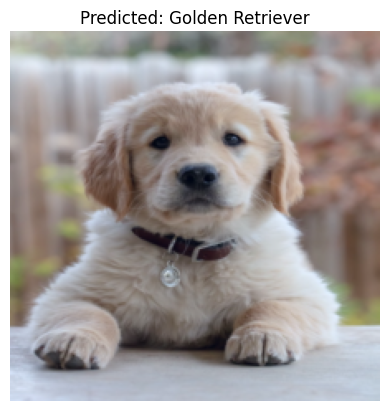

In [20]:
visualise_model_predictions(
    model,
    img_path='./Test/Golden-Retriever.jpg'
)

plt.ioff()
plt.show()